In [336]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from operator import truediv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [337]:
def preprocess_csv(file_path):
    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(file_path)
    
    # Handling missing values
    # Replace any missing values (NaN) with appropriate strategies
    # For numerical columns, you can use methods like mean, median, or interpolation
    df.fillna(df.mean(), inplace=True)  # Example: Replace missing values with column means
    
    # For categorical columns, you can use methods like mode or a constant value
    df.fillna('Unknown', inplace=True)  # Example: Replace missing values with 'Unknown'
    
    # Process or remodel the description columns
    # Depending on your specific use case, you can apply techniques like text preprocessing, feature extraction, or encoding
    
    # Text preprocessing: Remove special characters, convert to lowercase, etc.
    #df['description'] = df['description'].str.replace('[^\w\s]', '').str.lower()
    
    # Feature extraction: Extract relevant information from the description
    # You can use techniques like TF-IDF, word embeddings, or topic modeling to extract features
    
    # Encoding: Convert categorical description columns into numeric representations
    # Techniques like one-hot encoding or word embeddings can be useful
    
    # Return the preprocessed dataframe
    return df


In [338]:
def learnLanguage(file, doc2vec):
    
    
    data = pd.read_csv(file)
    X = pd.read_csv(doc2vec, index_col = False, delimiter = ',', header = None)
    y = data["Language"]
    
    y = pd.Series(y)
    # Assuming you have a feature matrix `X` and a target variable `y`
    # X should contain other features like doc2vec and word frequency counts
    # y should contain the language labels (with missing values)

    # Split the dataset into instances with and without missing language values
    X_with_language = X[~y.isnull()]
    y_with_language = y[~y.isnull()]
    X_missing_language = X[y.isnull()]

    # Split the dataset with language into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_with_language, y_with_language, test_size=0.2, random_state=42)

    # Train a Random Forest classifier on the instances with language
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Predict the missing language values using the trained model
    imputed_language = rf.predict(X_missing_language)

    # Merge the imputed language values with the original dataset
    y[y.isnull()] = imputed_language

    # Now you can proceed with your machine learning algorithm using the complete dataset
    return y

In [339]:
# Load the dataset
train_df = pd.read_csv('project_data_files/book_rating_train.csv')
test_df = pd.read_csv('project_data_files/book_rating_test.csv')

# Add the predicted languages to each entry
lang = learnLanguage('project_data_files/book_rating_train.csv', "project_data_files/book_text_features_doc2vec/train_desc_doc2vec100.csv")
train_df['Language'] = lang

In [340]:
def add_letter_to_cols(df, letter):
    for column in df.columns:
        new_name = letter + str(column)
        df.rename(columns={column: new_name}, inplace=True)

In [341]:
train_df = train_df.drop('Name', axis=1)
train_df = train_df.drop('Description', axis=1)
train_df = train_df.drop('Authors', axis=1)


# Remove the title, description and replace with doc2vec
book_name_features = pd.read_csv(r"project_data_files/book_text_features_doc2vec/train_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
add_letter_to_cols(book_name_features, "n")

book_desc_features = pd.read_csv(r"project_data_files/book_text_features_doc2vec/train_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
add_letter_to_cols(book_desc_features, "d")

book_auth_features = pd.read_csv(r"project_data_files/book_text_features_doc2vec/train_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)
add_letter_to_cols(book_auth_features, "a")

combined_df = pd.concat([train_df, book_name_features, book_desc_features, book_auth_features], axis=1)

In [342]:
# Function that converts a categorical feature into nominal, while maintaing categorical properties
def numericise_categorical_data(df, feature):
    df[feature] = df[feature].astype(str)
    df[feature] = df[feature].astype('category')
    df_encoded = pd.get_dummies(df, columns=[feature])
    
    encoder = LabelEncoder()
    df[feature] = encoder.fit_transform(df[feature])

In [343]:
# Perform label encoding for publishers, language
label_encoder = LabelEncoder()
combined_df['Publisher'] = label_encoder.fit_transform(combined_df['Publisher'])

#combined_df = pd.concat([book_name_features, book_desc_features, train_df['rating_label']], axis=1)
# Separate the feature columns (X) and the target column (y)
X = combined_df.copy()
X = X.drop('rating_label', axis=1)
#X = X.drop('Publisher', axis=1)
X['Language'] = (X['Language'] == 'eng').astype(int)
y = combined_df['rating_label']

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X

,PublishYear,PublishMonth,PublishDay,Publisher,Language,pagesNumber,n0,n1,n2,n3,...,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19
0,2005,6,1,3664,1,48,0.052262,-0.263308,0.026872,0.128574,...,0.329671,0.343979,0.018261,0.115687,-0.111172,0.068306,0.158065,0.053510,-0.136804,-0.084448
1,1991,10,1,1108,1,364,-0.129112,0.021312,0.159166,-0.072448,...,0.400349,0.065201,0.349188,0.020555,0.281087,0.231422,0.129853,-0.213233,-0.081253,-0.204687
2,2005,3,31,810,1,32,-0.170058,0.052351,-0.013406,0.099001,...,0.225617,-0.004355,0.173353,0.087015,0.106534,0.040950,0.209152,-0.215313,-0.177547,-0.178094
3,2004,9,1,480,1,293,0.250849,0.021555,0.091047,-0.041589,...,0.133304,-0.069995,0.206028,0.089625,0.157605,0.131767,0.244849,-0.321698,-0.198365,-0.208098
4,2005,7,7,2820,1,352,-0.041681,0.038051,-0.051164,-0.076813,...,0.224210,0.049880,0.003623,0.062291,-0.030742,0.130882,0.295086,-0.061550,-0.244197,-0.272161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23058,1997,8,1,7,1,120,0.007497,0.000220,0.019723,-0.003321,...,0.352087,-0.003458,0.148963,0.063023,0.207720,0.070757,0.372283,-0.202811,-0.110761,-0.332954
23059,2005,6,1,1603,1,32,-0.024484,0.000467,-0.015977,0.086630,...,0.036516,-0.076491,0.343184,-0.041826,0.242226,0.140699,0.104105,-0.140699,-0.004226,-0.291587
23060,1989,2,15,3220,1,132,-0.099309,-0.046230,-0.033294,0.242591,...,0.359741,-0.077176,0.297625,0.172478,0.149067,-0.003060,0.270723,-0.324030,-0.264965,-0.269051
23061,1998,4,21,2550,1,136,-0.038388,0.065679,-0.159324,-0.048682,...,0.266749,-0.052155,0.195081,0.126226,0.097224,0.052020,0.191786,-0.234276,-0.214879,-0.224103


In [345]:
# Create the decision tree classifier object
tree = DecisionTreeClassifier()

# Train the model using the training data
tree.fit(X_train, y_train)

tree_text = export_text(tree)

importances = tree.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Print the feature importances
#print("mean importance value: ", feature_importances['Importance'].mean())
#print(feature_importances.head(40))
#print(max(feature_importances['Importance']))

tree_text = export_text(tree)

In [346]:
scores = cross_val_score(tree, X, y, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)
print("Average Accuracy:", np.mean(scores))

Cross-Validation Scores: [0.56622588 0.5660091  0.56687622 0.56006071 0.56548135]
Average Accuracy: 0.5649306543275171


In [350]:
# Make predictions on the testing data derived from training data
predictions = tree.predict(X_test)

combined = pd.concat([pd.Series(predictions), y_test.reset_index()], axis=1)

In [351]:
from sklearn.metrics import confusion_matrix
# Assuming you have the predicted labels and true labels in pandas dataframes
predicted_labels = pd.DataFrame(predictions)
true_labels = y_test.reset_index()['rating_label']


In [352]:
def confusion_matrix_plot(y_pred, ys):
    
    labels = ys.unique()
    print(labels)
    
    cm = confusion_matrix(ys, y_pred, labels = labels)
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()
    
    evalMetrics = classification_report(ys, y_pred, digits=3)
    print(evalMetrics)
    
    return cm

[4. 3. 5.]


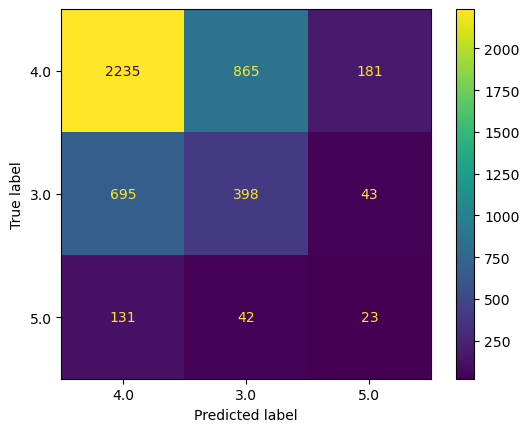

              precision    recall  f1-score   support

         3.0      0.305     0.350     0.326      1136
         4.0      0.730     0.681     0.705      3281
         5.0      0.093     0.117     0.104       196

    accuracy                          0.576      4613
   macro avg      0.376     0.383     0.378      4613
weighted avg      0.598     0.576     0.586      4613



array([[2235,  865,  181],
       [ 695,  398,   43],
       [ 131,   42,   23]], dtype=int64)

In [353]:
# GENERATE CONFUSION MATRIX AND EVALUATION METRICS
confusion_matrix_plot(predicted_labels, true_labels)

In [355]:
# Evaluate the model
accuracy = tree.score(X_test, y_test)
accuracy

0.5757641448081509

In [358]:
######Formatting TEST DATA ########

dataT = pd.read_csv("project_data_files/book_rating_test.csv")

dataT.pop("Name")
dataT.pop("Description")
dataT.pop("Authors")


# Load in doc2vec features and add letter to start of name of value to make more identifiable
book_desc_featuresT = pd.read_csv(r"project_data_files/book_text_features_doc2vec/test_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
add_letter_to_cols(book_desc_featuresT, "d")

book_name_featuresT = pd.read_csv(r"project_data_files/book_text_features_doc2vec/test_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
add_letter_to_cols(book_name_featuresT, "n")

book_authors_featuresT = pd.read_csv(r"project_data_files/book_text_features_doc2vec/test_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)
add_letter_to_cols(book_authors_featuresT, "a")

#learning Languages
langs = learnLanguage("project_data_files/book_rating_test.csv", "project_data_files/book_text_features_doc2vec/test_desc_doc2vec100.csv")
dataT['Language'] = langs

# Numericise language and publisher features
dataT['Language'] = (dataT['Language'] == 'eng').astype(int)
numericise_categorical_data(dataT, 'Publisher')

# Combine all gathered features into one dataframe
combinedT_df = pd.concat([dataT, book_name_featuresT, book_desc_featuresT, book_authors_featuresT], axis=1)

# Perform label encoding for publishers, language
label_encoder = LabelEncoder()
combinedT_df['Publisher'] = label_encoder.fit_transform(combinedT_df['Publisher'])
combinedT_df['Language'] = label_encoder.fit_transform(combinedT_df['Language'])

rf = DecisionTreeClassifier()
rf.fit(X, y)
predictions = rf.predict(combinedT_df)

In [359]:
###GENERATING PREDICTIONS######
# Creating csv file for Kaggle upload

predictions = pd.Series(predictions, name = 'rating_label')
print(predictions)

predictions.to_csv("DTCPred.csv",index_label = 'id', index = True, na_rep='NULL')

df = pd.read_csv("DTCPred.csv")
df['id'] = df['id'] + 1
df.to_csv("DTCPred.csv", index = False, na_rep='NULL')

0       4.0
1       3.0
2       4.0
3       4.0
4       3.0
       ... 
5761    4.0
5762    3.0
5763    3.0
5764    4.0
5765    4.0
Name: rating_label, Length: 5766, dtype: float64


In [360]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

In [361]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7103836982440928


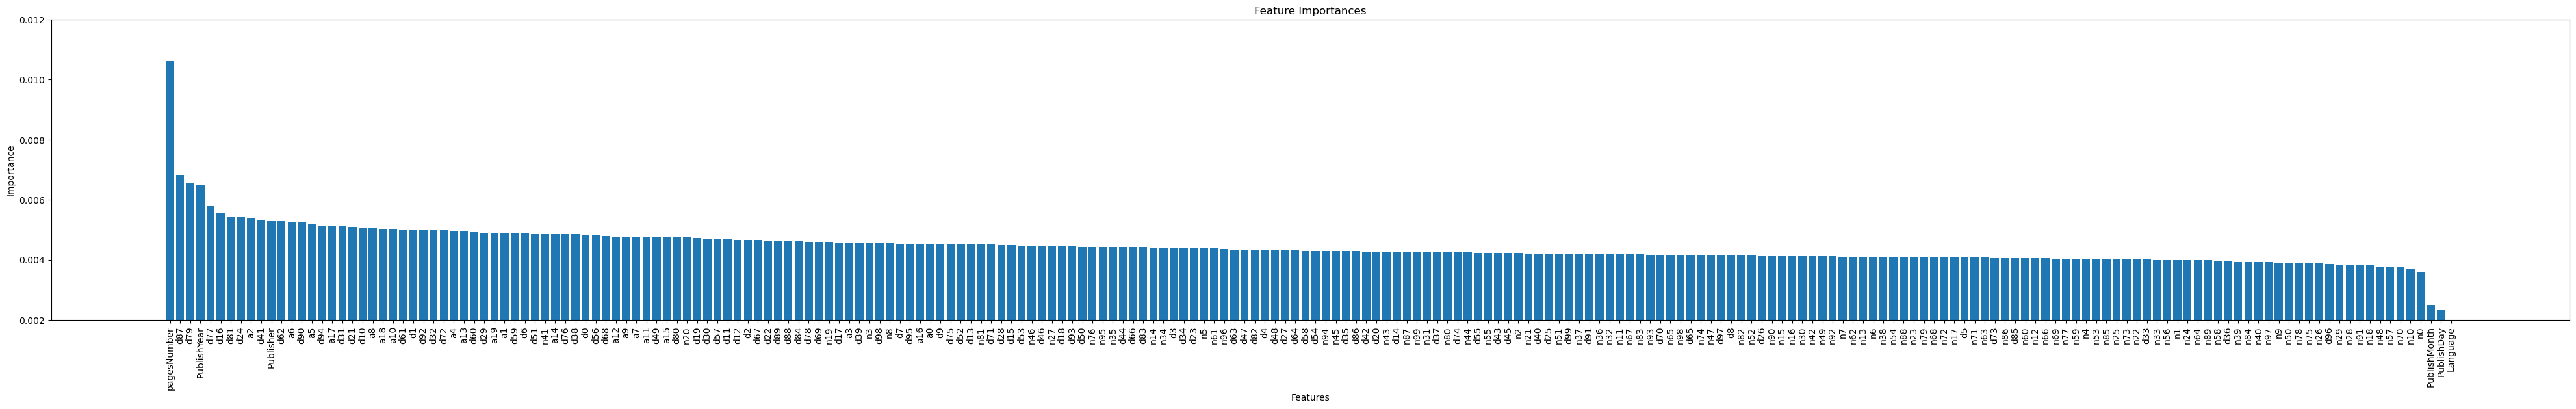

In [362]:
feature_importances = rf.feature_importances_

# Assuming you have trained a random forest model 'rf' and have a pandas DataFrame 'df'
feature_importances = rf.feature_importances_
feature_names = X_train.columns.tolist()

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(50, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances)
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.ylim(0.002, 0.012)
plt.show()

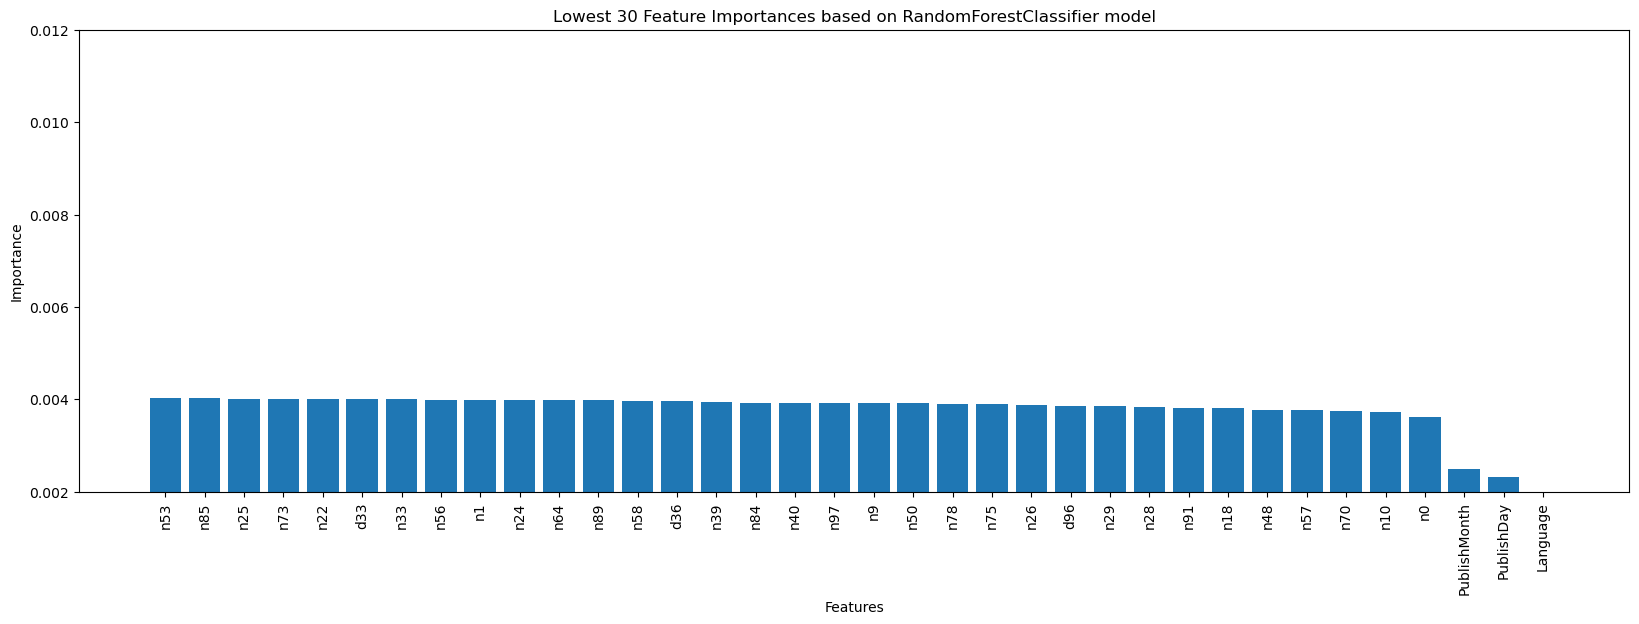

In [363]:
# Select only the top 20 features
top_feature_importances = sorted_feature_importances[190:]
top_feature_names = sorted_feature_names[190:]

# Plot the feature importances for the top 20 features
plt.figure(figsize=(20, 6))
plt.bar(range(len(top_feature_importances)), top_feature_importances)
plt.xticks(range(len(top_feature_importances)), top_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Lowest 30 Feature Importances based on RandomForestClassifier model')

plt.ylim(0.002, 0.012)
plt.show()

In [ ]:
##############################################

'''Code for language classifier, decision tree classifier, feature importance graphs, learning curves were all inspired by,
adapted from code made by or is code made by the AI Tool, ChatGPT'''